# Systemy Rekomendacyjne - Realizacja zadania 10 

###  Podsystem analizy wyników eksperymentów (Experiment Results Analyzer) wraz z niezbędnymi funkcjami systemu oceny działania systemu rekomendacyjnego (Evaluator)

Realizacja zadania koncentruje się na zapewnieniu poprawnego pomiaru trafności rekomendacji dla dwóch najbardziej typowych scenariuszy aplikacyjnych systemów rekomendacyjnych [Herlocker]: 
- rekomendacji <b>Top-n</b> (przy czym N to długość listy rekomendacyjnej) 
- rekomendacji tożsamej <b>klasyfikacji binarnej</b> – należy zaimplementować dwa odrębne tryby pomiaru jakości rekomendacji.

Należy zapewnić pomiar jakości zgodnie z powszechnie przyjętymi miarami – właściwymi dla danego trybu pomiaru jakości:
- dla trybu <b>Top-n</b>: *P@N* i *R@N* dla kilku różnych wartości N – najlepiej w postaci krzywej (tj. łamanej) P(R),
- dla trybu  <b>klasyfikacji binarnej</b>: *ACC (accuracy)*, *AUC (Area under Receiver Operating Characteristic Curve)* – najlepiej wraz z krzywą ROC.

Plik <b>*rating.csv*</b> zawiera 20 milionów ocen i został pobrany ze strony: http://files.grouplens.org/datasets/movielens/ml-20m-README.html 

### Teoria (źródło: https://developers.google.com/machine-learning/crash-course/classification/video-lecture)
<b> Regresja logistyczna </b> - wiele problemów wymaga oszacowania prawdopodobieństwa jako wyniku. Regresja logistyczna umożliwia obliczenie tego prawdopodobieństwa na jeden z dwóch sposobów:
- <b> "Jak jest" </b>  : Załóżmy, że tworzymy regresję logistyczną dla modelu który przewiduje prawdopodobieństwo, że dany film jest rekomendowany danemu użytkownikowi. Będzie ona miała postać: <b>*p(movieID | userID)*</b>
- <b> Binarnie </b> : Celem jest predykcja czy dany film jest zarekomendowany danemu użytkownikowi czy nie. Wynikiem jest wartość 0 lub 1.

<b> Thresholding </b> - próg dla którego decydujemy czy film jest rekomendowany czy nie.

#### Klasyfikacje: True vs False oraz Positive vs Negative
Mając film o danym ID, oraz użytkownika o danym ID, można zdefiniować czy film jest rekomendowany na poniższe sposoby:
- <b>Klasa Positive:</b> Film rekomendowany danemu użytkownikowi
- <b>Klasa Negative:</b> Film nierekomendowany danemu użytkownikowi

<b><br> True Positive (TP): </b> Film został zarekomendowany i faktycznie jest rekomendowany
<b><br> True Negative (TN):</b> Film nie został zarekomendowany i faktycznie nie powinien być rekomendowany
<b><br> False Positive (FP):</b> Film został zarekomendowany a nie powinien być rekomendowany
<b><br> False Negative (FN):</b> Film nie został zarekomendowany a powinien byc rekomendowany

Zatem <b>True Positive</b> jest wynikiem, w którym model poprawnie przewiduje klasę pozytywną, a <b>True Negative</b> jest wynikiem, w którym model poprawnie przewiduje klasę negatywną.
<br>
<b>False Positive</b> jest wynikiem, w którym model niepoprawnie przewiduje klasę pozytywną, a <b>False Negative</b> w którym model niepoprawnie przewiduje klasę negatywną.

### Accuracy
<b>Accuracy</b> - jest miarą oceny modeli klasyfikacji. 
<br> <b>*Accuracy*</b> = *(Liczba trafnych predykcji / Liczba wszystkich predykcji)*
<br> <b>*Liczba trafnych predykcji*</b> = *TP + TN *
<br> <b>*Liczba wszystkich predykcji*</b> = *TP + TN + FP + FN*
<br> A zatem ostateczny wzór ma postać: <b>*Accuracy*</b> = *(TP + TN) / (TP + TN + FP + FN)* 

### Krzywa ROC 
<b>ROC Curve</b> (Receiver Operating Characteristic Curve) - jest wykresem pokazującym wydajność modelu klasyfikacyjnego przy wszystkich prograch klasyfikacji (Threshold). Krzywa przedstawia dwa parametry:
- <b>True Positive Rate (TPR) </b>- jest synonimem Recall i definiowane jest wzorem: <b>*TPR*</b> = *TP / (TP + FN)*
- <b>False Positive Rate (FPR)</b> - definiowane jest wzorem: <b>*FPR*</b> = *FP / (FP + TN)*

Krzywa ROC jest wykresem postaci TPR(FPR) dla różnych progów klasyfikacji. Obniżenie Threshold powoduje, że więcej pozycji jest pozytywne, tym samym zwiększana jest liczba FP oraz TP. 

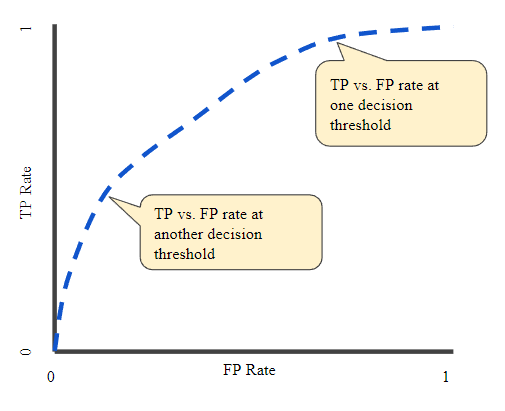

In [1]:
from IPython.display import Image
Image(filename="E:\SEMESTR VII\Systemy rekomendacyjne/ROCCurve.png", width=353, height=306)

### AUC  (Area Under the ROC Curve)
Pole pod krzywą ROC. Liczony jest cały obszar pod krzywą ROC od punktu (0,0) do (1,1).

<b>Precision</b> - jaka część pozytywnych identyfikacji była poprawna?
<br> Wyrażane jest wzorem: <b>*Precision*</b> = *TP / (TP + FP)*
<br>
<br> <b>Recall</b> - jaka część rzeczywistych pozytywów została zidentyfikowana poprawnie?
<br> Wyrażane jest wzorem: <b>*Recall*</b> = *TP / (TP + FN)*

### Implementacja 

In [1]:
#biblioteki analizy danych
import pandas as pd
import numpy as np

#biblioteki wizualizacji danych
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#ścieżka do danych
source = 'E:\SEMESTR VII\Systemy rekomendacyjne\MovieLens Data/'

In [4]:
#wczytanie danych
rating = pd.read_csv(source + 'rating.csv', sep=',')

### 1) Opis tabeli rating.csv

Plik <b>rating.csv</b> – informacje o ocenach filmów wystawionych przez użytkowników
<br><b>*userId*</b> – identyfikator użytkownika który wystawił ocenę
<br><b>*movieId*</b> – identyfikator ocenionego filmu
<br><b>*rating*</b> – ocena w 5 gwiazdkowej skali: 0,5 – 5.0
<br><b>*timestamp*</b> – czas wystawienia oceny



In [5]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


### 2) Przygotowanie tabeli rating.csv 

#### a) Usunięcie zbędnej kolumny 'timestamp'


In [11]:
#ścieżka do danych
source = 'E:\SEMESTR VII\Systemy rekomendacyjne\MovieLens Data/'
#wczytanie danych
rating = pd.read_csv(source + 'rating.csv', sep=',')
columns = ['userId','movieId','rating']
new_rating = rating[columns]
new_rating.to_csv(source + 'rating files/rating.csv', index=False)

In [12]:
#Rozmiar tabeli
new_rating.shape

(20000263, 3)

In [13]:
new_rating.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


#### b) Przeliczenie rekomendacji.
Ocena wyższa lub równa 4 = Rekomendowane (1)
<br> Ocena niższa niż 4 = Nierekomendowane (0)

In [14]:
#Wczytanie pliku przygotowanego w podpunkcie a)
rating = pd.read_csv(source + 'rating files/rating.csv', sep=',')

In [15]:
#Wygenerowanie wartości rekomendacji na podstawie ocen
rating['rating'] = np.where(rating['rating'] >= 4, 1, 0)

In [16]:
#Zmiana nazwy kolumny
rating = rating.rename(columns={'rating': 'is_recommended'})
rating.head()

,userId,movieId,is_recommended
0,1,2,0
1,1,29,0
2,1,32,0
3,1,47,0
4,1,50,0


In [26]:
#Zapisanie do pliku
rating.to_csv(source + 'rating files/ratingTrueTable.csv', index=False)

### 3) Przygotowanie plików od systemu rekomendacyjnego
Pliki mają postać: userId (int), movieId (int), is_recommended (float)
<br>
<br> Wyróżniane są 3 przypadki:
<br>  a) możliwie najgorszy system rekomendacyjny (wartości losowe - accuracy około 50%)
<br>  b) możliwie najlepszy system rekomendacyjny (wszystkie predykcje trafne)
<br>  c) pozornie najgorszy system rekomendacyjny (wszystkie wartości nietrafione)

In [276]:
#Nazwa pliku z tablicą prawdy
truetable = 'ratingTrueTable.csv'

#### a) Możliwie najgorszy system rekomendacyjny  
Wartości są losowe

In [253]:
#Wczytanie pliku
rating = pd.read_csv(source + 'rating files/' + truetable, sep=',')
#Wypełnienie kolumny is_recommended losowymi wartościami z zakresu 0-1
rating['is_recommended'] = np.random.uniform(0.0,1.0,rating.shape[0])

#Zapisanie do pliku
rating.to_csv(source + 'rating files/mozliwieNajgorszyPrzypadek.csv', index=False)

#### b) Możliwie najlepszy system rekomendacyjny 
Wszystkie predykcje są trafione

In [13]:
#Wczytanie pliku
rating = pd.read_csv(source + 'rating files/' + truetable, sep=',')

#Zapisanie kopii do pliku
rating.to_csv(source + 'rating files/mozliwieNajlepszyPrzypadek.csv', index=False)

#### c) Pozornie najgorszy system rekomendacyjny
Wszystkie wartości są nietrafione

In [277]:
#Wczytanie tablicy prawdy
rating = pd.read_csv(source + 'rating files/' + truetable, sep=',')
#Wygenerowanie zanegowanych wartości rekomendacji na podstawie tablicy prawdy
rating['is_recommended'] = np.where(rating['is_recommended'] == 0, 1, 0)

#Zapisanie do pliku
rating.to_csv(source + 'rating files/pozornieNajgorszyPrzypadek.csv', index=False)

#### d) Przygotowanie pliku o Accuracy ~75% 

In [236]:
#Wczytanie pliku
rating = pd.read_csv(source + 'rating files/' + truetable, sep=',')

#Wypełnienie połowy wierszy is_recommended losowymi wartościami z zakresu 0-1. Reszta pozostaje bez zmian
rating['is_recommended'] = np.where(rating['is_recommended'] == 1, np.random.uniform(0.6,1.0,rating.shape[0]), np.random.uniform(0.0,1.0,rating.shape[0]))

#Zapisanie do pliku
rating.to_csv(source + 'rating files/przecietnyPrzypadek.csv', index=False)

### 4) Liczenie Accuracy 

In [278]:
import numpy as np
from sklearn.metrics import accuracy_score

In [279]:
#Tablica prawdy
trueTable = pd.read_csv(source + 'rating files/ratingTrueTable.csv', sep=',')
y_true = trueTable['is_recommended']

#### a)  Accuracy dla możliwie najgorszego przypadku

In [259]:
#Accuracy dla możliwie najgorszego przypadku
predicted = pd.read_csv(source + 'rating files/mozliwieNajgorszyPrzypadek.csv', sep=',')
y_pred = np.where(predicted['is_recommended'] > 0.5, 1, 0)
#Wynik
print("Accuracy", accuracy_score(y_true, y_pred))

Accuracy 0.5000070249076225


#### b)  Accuracy dla możliwie najlepszego systemu rekomendacyjnego

In [39]:
#Accuracy dla możliwie najlepszego systemu rekomendacyjnego
predicted = pd.read_csv(source + 'rating files/mozliwieNajlepszyPrzypadek.csv', sep=',')
y_pred = predicted['is_recommended']
#Wynik
print("Accuracy", accuracy_score(y_true, y_pred))

Accuracy 1.0


#### c)  Accuracy dla pozornie najgorszego systemu rekomendacyjnego

In [280]:
#Accuracy dla pozornie najgorszego systemu rekomendacyjnego
predicted = pd.read_csv(source + 'rating files/pozornieNajgorszyPrzypadek.csv', sep=',')
y_pred = predicted['is_recommended']
#Wynik
print("Accuracy", accuracy_score(y_true, y_pred))

Accuracy 0.0


#### d)  Accuracy dla przeciętnego systemu rekomendacyjnego

In [260]:
#Accuracy dla przeciętnego systemu rekomendacyjnego
predicted = pd.read_csv(source + 'rating files/przecietnyPrzypadek.csv', sep=',')
y_pred = np.where(predicted['is_recommended'] > 0.5, 1, 0)

#Wynik
print("Accuracy", accuracy_score(y_true, y_pred))

Accuracy 0.7498250398007266


### 5) ROC Curve

In [282]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

In [283]:
#Tablica prawdy
trueTable = pd.read_csv(source + 'rating files/ratingTrueTable.csv', sep=',')
y_true = trueTable['is_recommended']

### a) Możliwie najgorszy przypadek 

In [261]:
predicted = pd.read_csv(source + 'rating files/mozliwieNajgorszyPrzypadek.csv', sep=',')
y_pred = predicted['is_recommended']

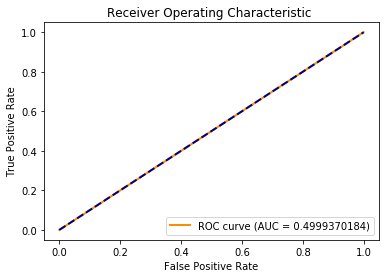

In [262]:
#Obliczenie False Positive Rate, True Positive Rate
fpr, tpr, _ = roc_curve(y_true,  y_pred)
#Obliczenie AUC
auc = metrics.roc_auc_score(y_true, y_pred)

#Wygenerowanie wykresu
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.10f)' % auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic ')
plt.legend(loc="lower right")
plt.show()

### b) Możliwie najlepszy przypadek 

In [46]:
#Możliwie najlepszy przypadek
predicted = pd.read_csv(source + 'rating files/mozliwieNajlepszyPrzypadek.csv', sep=',')
y_pred = predicted['is_recommended']

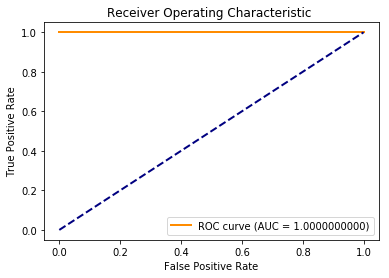

In [47]:
#Obliczenie False Positive Rate, True Positive Rate
fpr, tpr, _ = roc_curve(y_true,  y_pred)
#Obliczenie AUC
auc = metrics.roc_auc_score(y_true, y_pred)

#Wygenerowanie wykresu
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.10f)' % auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic ')
plt.legend(loc="lower right")
plt.show()

### c) Pozornie najgorszy przypadek 

In [281]:
#Możliwie najgorszy przypadek
predicted = pd.read_csv(source + 'rating files/pozornieNajgorszyPrzypadek.csv', sep=',')
y_pred = predicted['is_recommended']

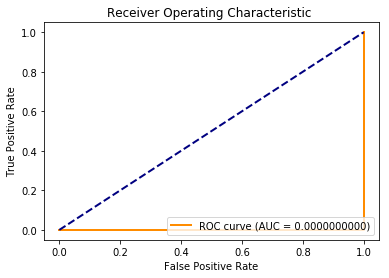

In [284]:
fpr, tpr, _ = roc_curve(y_true,  y_pred)
auc = metrics.roc_auc_score(y_true, y_pred)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.10f)' % auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic ')
plt.legend(loc="lower right")
plt.show()

### d) Acc ~ 75% 

In [239]:
#Możliwie najgorszy przypadek
predicted = pd.read_csv(source + 'rating files/przecietnyPrzypadek.csv', sep=',')
y_pred = predicted['is_recommended']

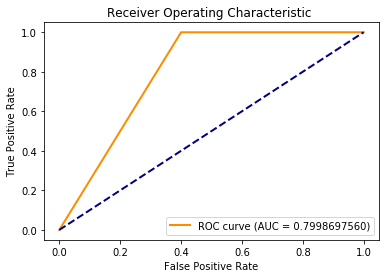

In [242]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true,  y_pred)

auc = metrics.roc_auc_score(y_true, y_pred)
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.10f)' % auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic ')
plt.legend(loc="lower right")
plt.show()

### 6) Precision / Recall 

In [285]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

In [286]:
#Tablica prawdy
trueTable = pd.read_csv(source + 'rating files/ratingTrueTable.csv', sep=',')
trueTable = trueTable[0:100]
y_train = trueTable['is_recommended']
y_train = y_train.as_matrix()

### a) Możliwie najgorszy przypadek 

In [291]:
#Możliwie najgorszy przypadek
predicted = pd.read_csv(source + 'rating files/mozliwieNajgorszyPrzypadek.csv', sep=',')
y_test = predicted['is_recommended']
y_test = y_test[0:100]
y_test = y_test.as_matrix()

Average precision-recall score: 0.50


Text(0.5,1,'2-class Precision-Recall curve: Average Precision=0.50')

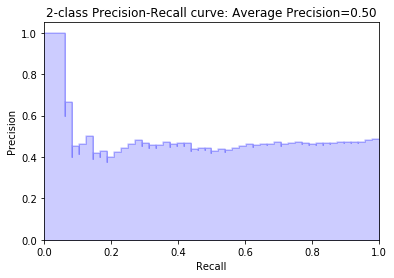

In [292]:
#Obliczenie precision i recall
precision, recall, _ = precision_recall_curve(y_train, y_test)

average_precision = average_precision_score(y_train, y_test)

#Generowanie wykresu
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Average Precision={0:0.2f}'.format(
          average_precision))

### b) Możliwie najlepszy przypadek 

In [295]:
#Możliwie najgorszy przypadek
predicted = pd.read_csv(source + 'rating files/mozliwieNajlepszyPrzypadek.csv', sep=',')
y_test = predicted['is_recommended']
y_test = y_test[0:100]
y_test = y_test.as_matrix()

Average precision-recall score: 1.00


Text(0.5,1,'2-class Precision-Recall curve: Average Precision=1.00')

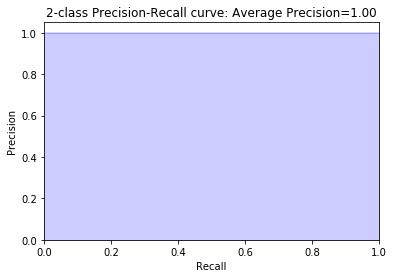

In [296]:
#Obliczenie precision i recall
precision, recall, _ = precision_recall_curve(y_train, y_test)

average_precision = average_precision_score(y_train, y_test)

#Generowanie wykresu
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Average Precision={0:0.2f}'.format(
          average_precision))

### c) Pozornie najgorszy przypadek 

In [303]:
#Możliwie najgorszy przypadek
predicted = pd.read_csv(source + 'rating files/pozornieNajgorszyPrzypadek.csv', sep=',')
y_test = predicted['is_recommended']
y_test = y_test[0:100]
y_test = y_test.as_matrix()

In [305]:
y_train

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0], dtype=int64)

In [306]:
y_test

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1], dtype=int64)

Text(0.5,1,'2-class Precision-Recall curve: Average Precision=0.48')

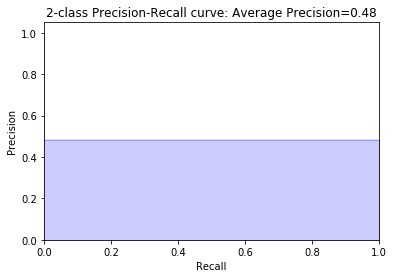

In [308]:
#Obliczenie precision i recall
precision, recall, _ = precision_recall_curve(y_train, y_test)

average_precision = average_precision_score(y_train, y_test)

#Generowanie wykresu
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Average Precision={0:0.2f}'.format(
          average_precision))

In [289]:
precision

array([0.48, 0.  , 1.  ])

In [290]:
recall

array([1., 0., 0.])

### d) Acc ~ 75% 

In [299]:
#Możliwie najgorszy przypadek
predicted = pd.read_csv(source + 'rating files/przecietnyPrzypadek.csv', sep=',')
y_test = predicted['is_recommended']
y_test = y_test[0:100]
y_test = y_test.as_matrix()

Average precision-recall score: 0.71


Text(0.5,1,'2-class Precision-Recall curve: Average Precision=0.71')

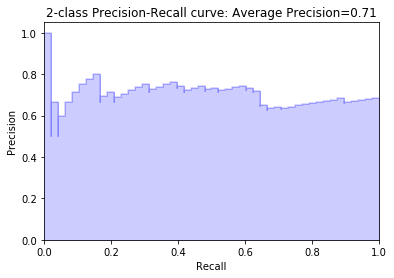

In [300]:
#Obliczenie precision i recall
precision, recall, _ = precision_recall_curve(y_train, y_test)

average_precision = average_precision_score(y_train, y_test)

#Generowanie wykresu
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Average Precision={0:0.2f}'.format(
          average_precision))